In [1]:
# pip install numpy matplotlib pylatexenc scipy qiskit qiskit-machine-learning qiskit-algorithms tensorflow[and-cuda] torch qiskit-aer-gpu ipython 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear, Softmax, Sigmoid, Module
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [3]:
# Creating Circuit

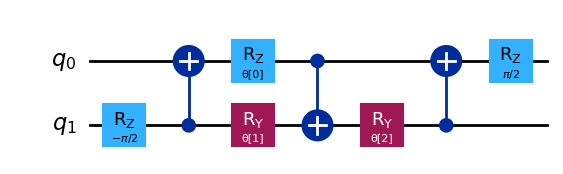

In [4]:
# Two qubit unitary as defined
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

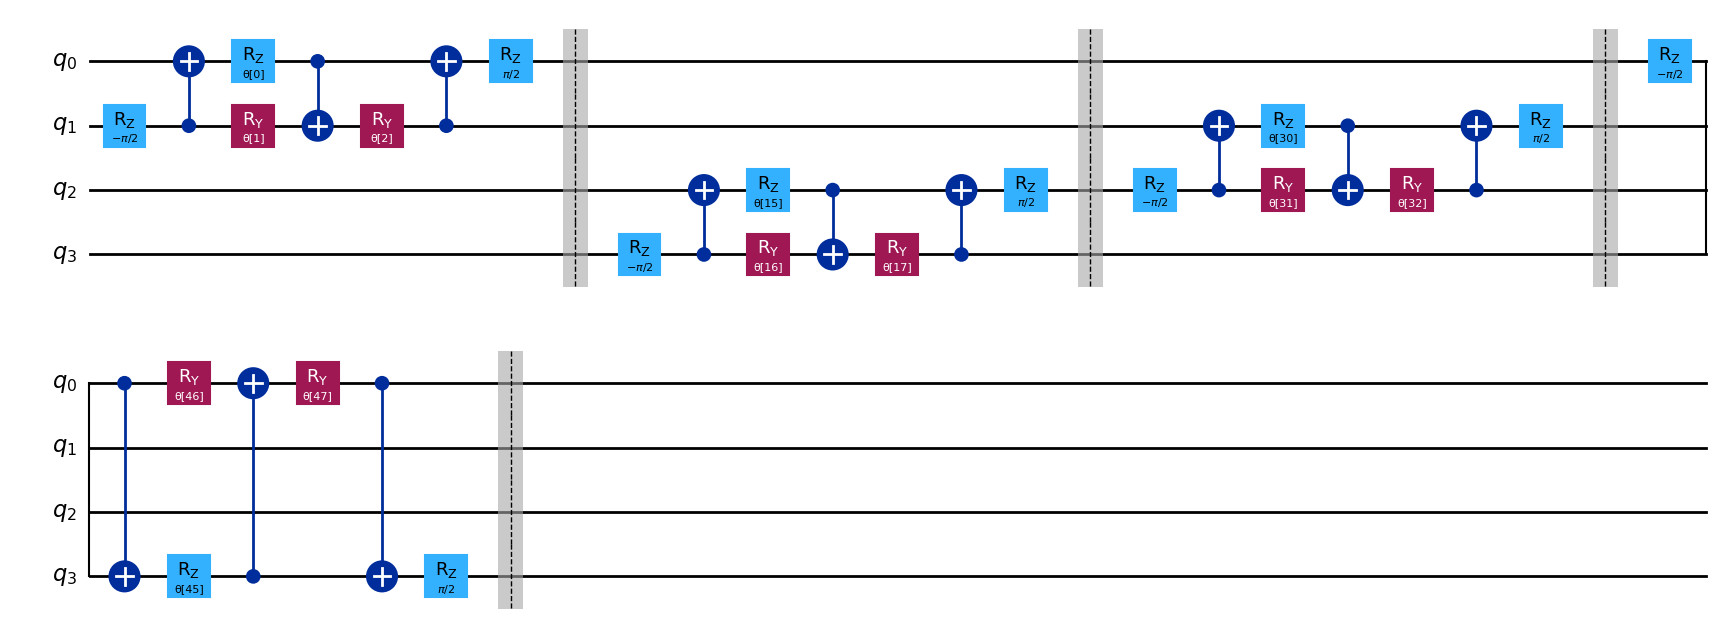

In [5]:
# Create Layer (Repeating Circuit on Neighboring Qubits).
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 15)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 15)]), [q1, q2])
        qc.barrier()
        param_index += 15

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

# Visual
circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

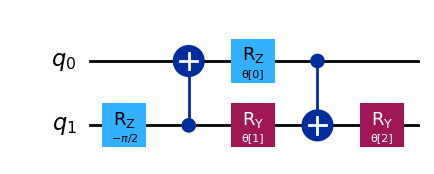

In [6]:
# Defining Pool Circuit
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target

# Visual
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

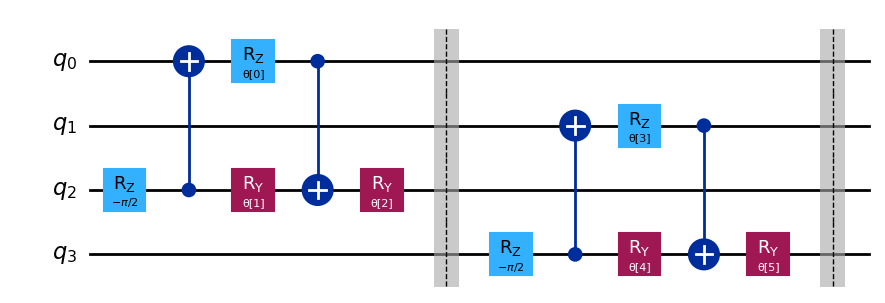

In [7]:
# Defining Pool Layer (Repeating Circuit on Neighboring Qubits)
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

# Visual
sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

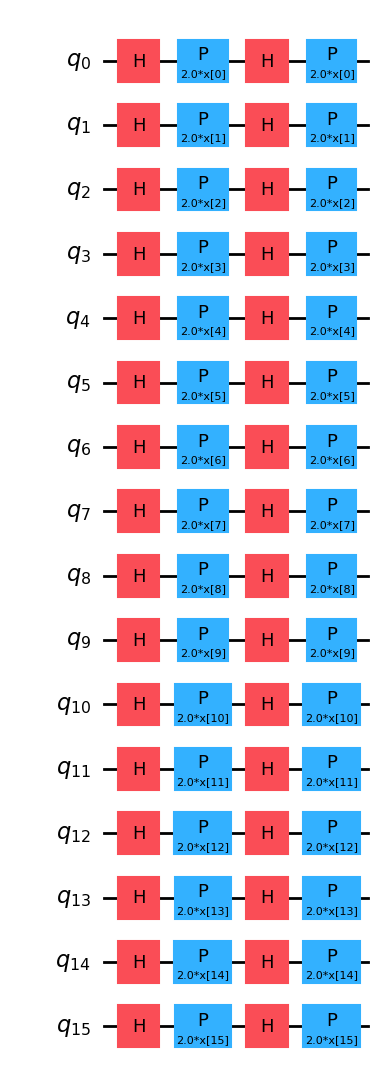

In [8]:
# Feature Map Instantiation
feature_map = ZFeatureMap(16)
feature_map.decompose().draw("mpl")

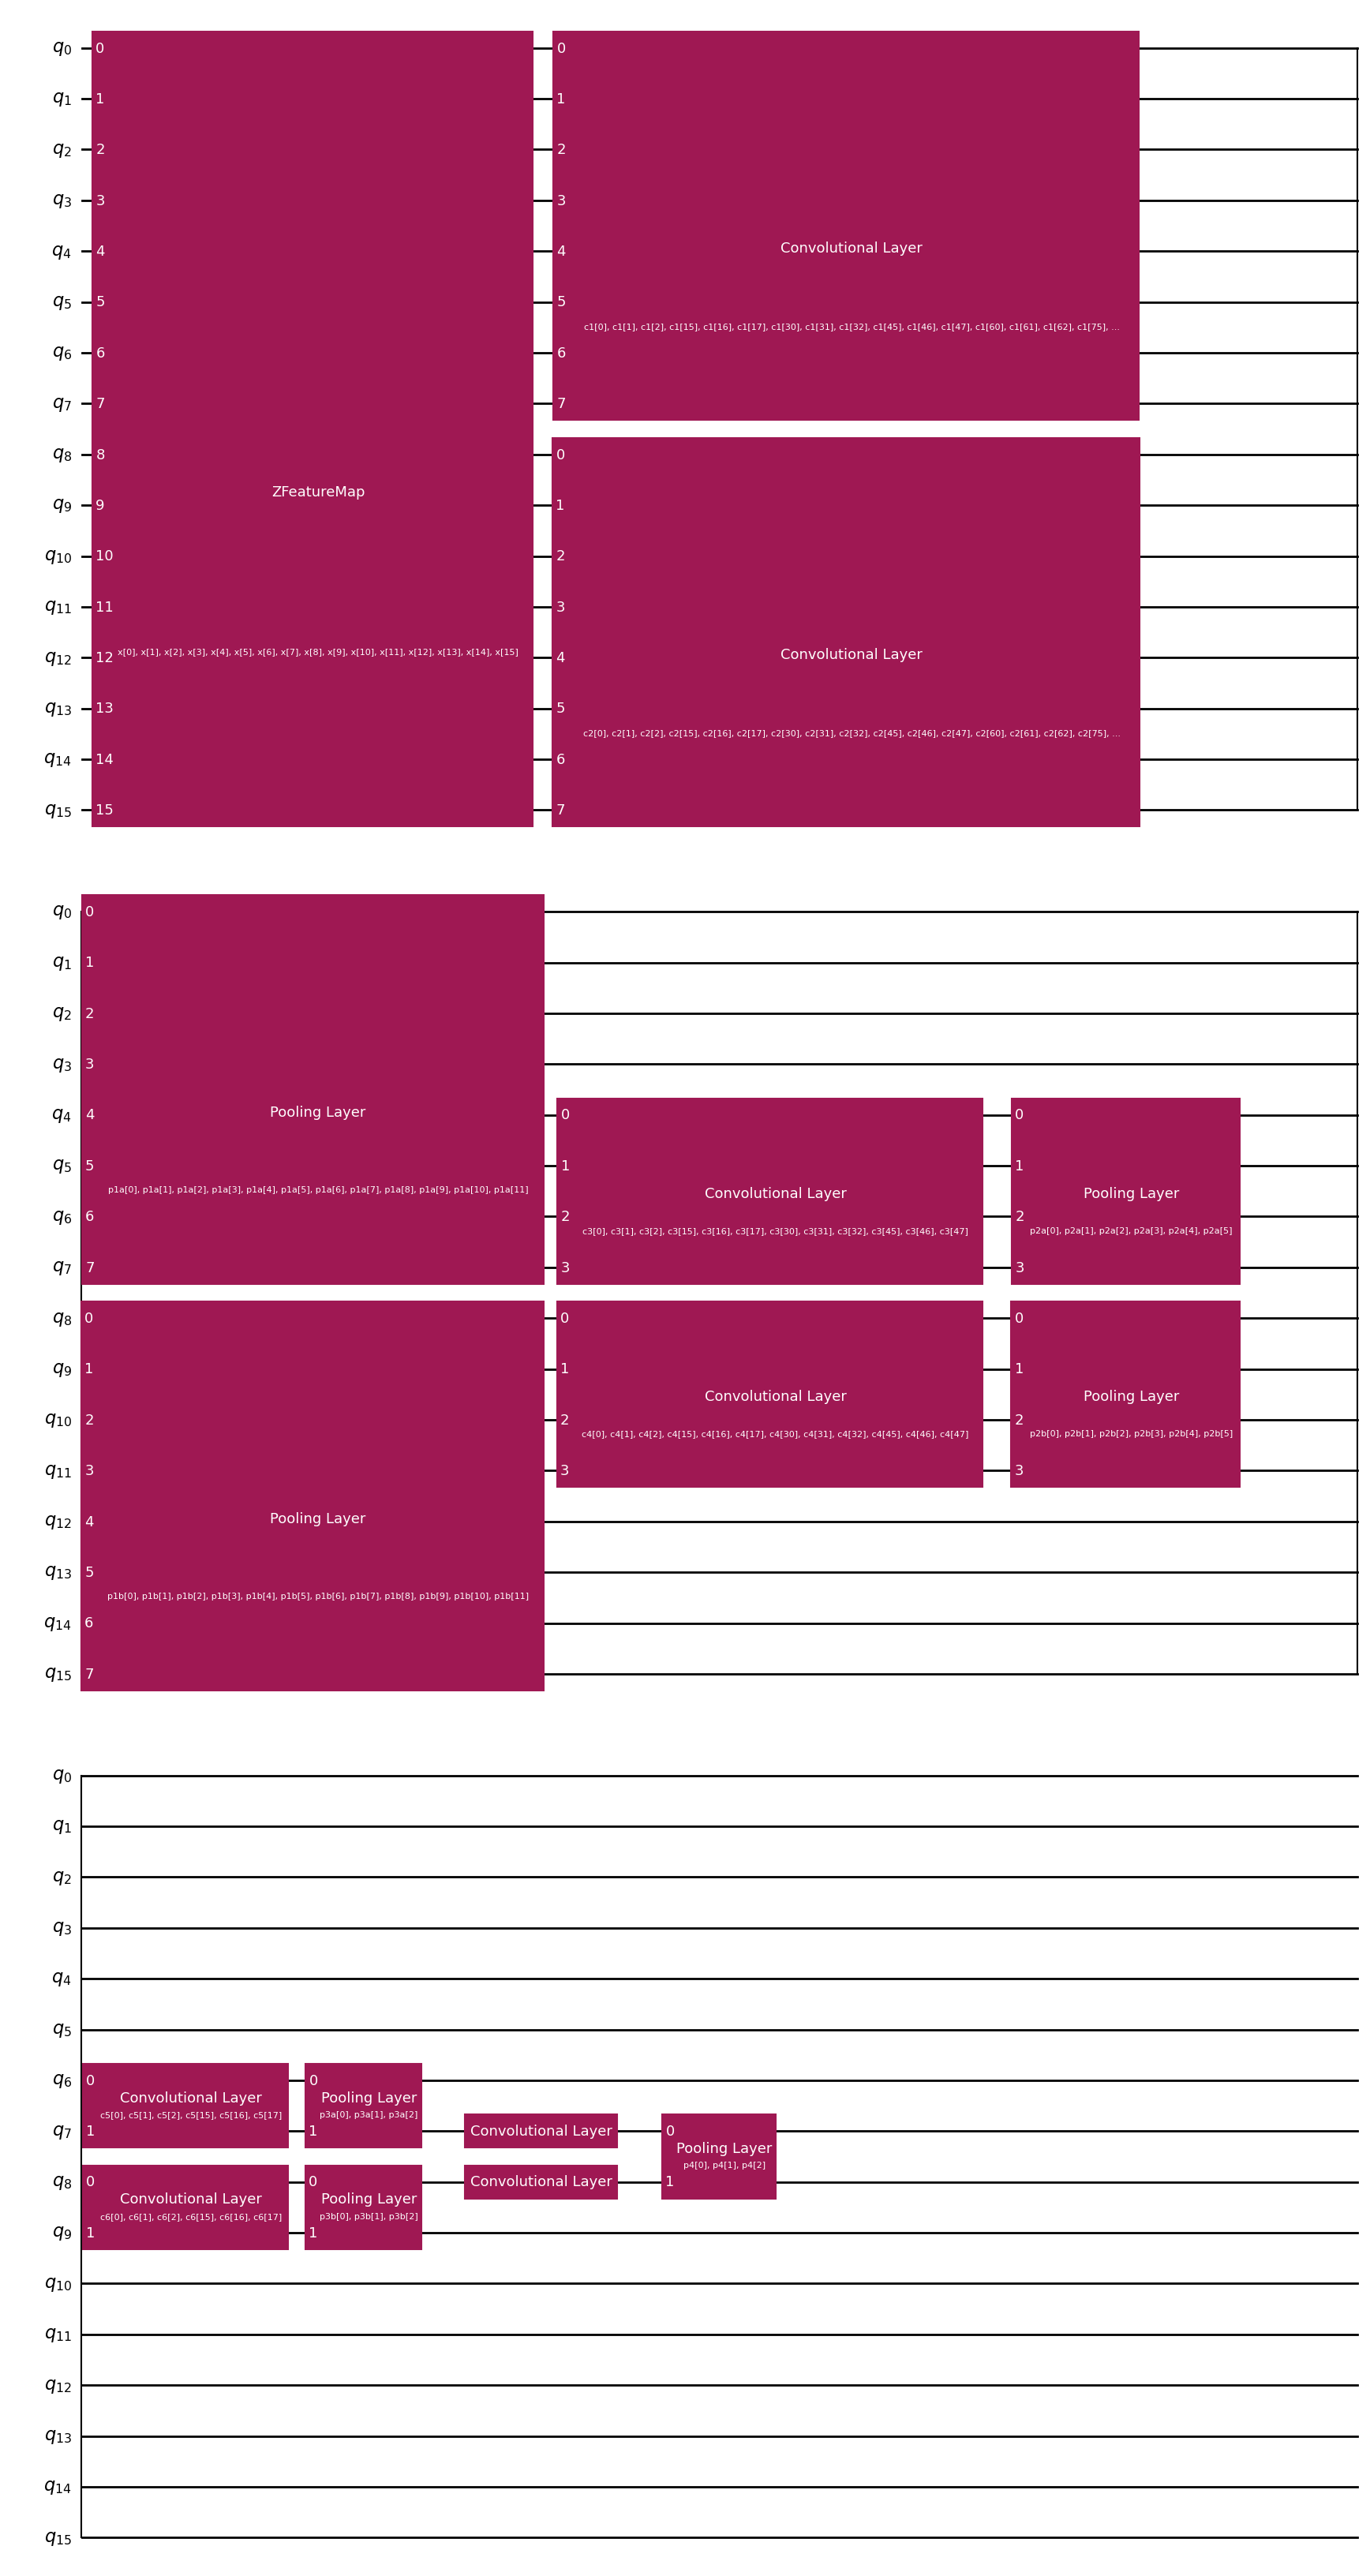

In [9]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    q_reg = QuantumRegister(16, "q_reg")
    ansatz = QuantumCircuit(q_reg, name="Ansatz")

    # First Convolutional Layer Set
    ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)
    ansatz.compose(conv_layer(8, "с2"), list(range(8,16)), inplace=True)

    # Second Convolutional Layer Set
    # ansatz.compose(conv_layer(16, "с2"), list(range(16)), inplace=True)
    
    # First Pooling Layer Set
    ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1a"), list(range(8)), inplace=True)
    ansatz.compose(pool_layer([4, 5, 6, 7], [0, 1, 2, 3], "p1b"), list(range(8,16)), inplace=True)

    # Third Convolutional Layer Set
    ansatz.compose(conv_layer(4, "с3"), list(range(4,8)), inplace=True)
    ansatz.compose(conv_layer(4, "с4"), list(range(8,12)), inplace=True)

    # Fourth Convolutional Layer Set
    # ansatz.compose(conv_layer(8, "с4"), list(range(4,12)), inplace=True)

    # Second Pooling Layer Set
    ansatz.compose(pool_layer([0, 1], [2, 3], "p2a"), list(range(4,8)), inplace=True)
    ansatz.compose(pool_layer([2, 3], [0, 1], "p2b"), list(range(8,12)), inplace=True)

    # Fifth Convolutional Layer Set
    ansatz.compose(conv_layer(2, "с5"), list(range(6,8)), inplace=True)
    ansatz.compose(conv_layer(2, "с6"), list(range(8,10)), inplace=True)

    # Sixth Convolutional Layer Set
    # ansatz.compose(conv_layer(4, "с6"), list(range(6,10)), inplace=True)

    # Third Pooling Layer Set
    ansatz.compose(pool_layer([0], [1], "p3a"), list(range(6,8)), inplace=True)
    ansatz.compose(pool_layer([1], [0], "p3b"), list(range(8,10)), inplace=True)

    # Seventh Convolutional Layer Set
    ansatz.compose(conv_layer(1, "с7"), list(range(7,8)), inplace=True)
    ansatz.compose(conv_layer(1, "с8"), list(range(8,9)), inplace=True)
    
    # Eighth Convolutional Layer Set
    # ansatz.compose(conv_layer(2, "с8"), list(range(7,9)), inplace=True)

    # Fourth Pooling Layer Set
    ansatz.compose(pool_layer([0], [1], "p4"), list(range(7,9)), inplace=True)

    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    return circuit

# Visual
display(create_QCNN().draw("mpl"))

In [10]:
# Creating/Formatting Data

In [11]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-09 10:05:52.337489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733767552.349982    5384 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733767552.353709    5384 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 10:05:52.366195: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [12]:
# Filter Values
a = 3
b = 4
def filter_abcd(x, y):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    return x,y

In [13]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11973
Number of filtered test examples: 1992


4


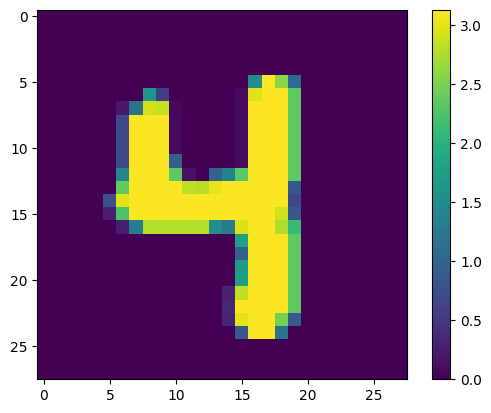

In [14]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [15]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1733767554.532938    5384 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


4


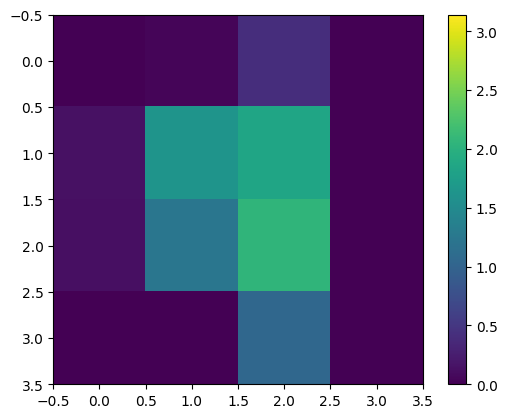

In [16]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [17]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
    return y_temp

In [18]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:128]
y = y[0:128]
x1 = x1[0:128]
y1 = y1[0:128]
print(x)
print(y)

[[0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 [0.         0.         0.0341942  ... 0.43195325 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.24765654 0.         0.        ]
 [0.         0.00176    0.00226285 ... 0.45030752 0.         0.        ]
 [0.         0.03494849 0.70274127 ... 0.9101693  0.01055997 0.        ]]
[1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1
 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0
 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0
 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 1 0]


In [19]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
    return(counta, countb)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [20]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (64, 64)
max_count = 64
balanced: (64, 64)
shuffled: (64, 64)
final: [[0.         0.         0.13979396 ... 0.03293706 0.48098174 0.        ]
 [0.         0.00276571 0.03042278 ... 0.74824965 0.         0.        ]
 [0.         0.02036567 0.30447927 ... 1.0318605  0.2805936  0.        ]
 ...
 [0.         0.         0.29894787 ... 0.2883879  0.09101693 0.        ]
 [0.         0.63284427 0.21446806 ... 0.4601132  0.25871938 0.        ]
 [0.00176    0.29567933 0.15010251 ... 0.         0.70927835 0.        ]]
[1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0
 1 1 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1
 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0
 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 0 1]


In [21]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [22]:
print(X,Y,X1,Y1)

tensor([[0.0000, 0.0000, 0.1398,  ..., 0.0329, 0.4810, 0.0000],
        [0.0000, 0.0028, 0.0304,  ..., 0.7482, 0.0000, 0.0000],
        [0.0000, 0.0204, 0.3045,  ..., 1.0319, 0.2806, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2989,  ..., 0.2884, 0.0910, 0.0000],
        [0.0000, 0.6328, 0.2145,  ..., 0.4601, 0.2587, 0.0000],
        [0.0018, 0.2957, 0.1501,  ..., 0.0000, 0.7093, 0.0000]],
       device='cuda:0') tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0') tensor([[0.0000, 0.1574, 0.1043,  ..., 0.0000, 0.5245, 0.0000],
        [0.0000, 0.2643, 0.0038,  ..., 0.1722, 0.6552, 0.0000],


In [23]:
# Training

In [24]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.qnn_module(x)
        x = self.sigmoid(x)
        return x

In [25]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

# Setting observables on 15th and 16th qubits.
observable_z8 = SparsePauliOp.from_sparse_list([("Z", [7], 1)], num_qubits=num_qubits)
observables = [observable_z8]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    observables = observables,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_5384/1541498244.py:21: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_5384/1541498244.py:21: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.00390625],
       [-0.0390625 ],
       [ 0.0078125 ],
       [-0.0625    ],
       [-0.03710938],
       [-0.015625  ],
       [ 0.03710938],
       [-0.02539062],
       [-0.08398438],
       [ 0.01757812],
       [ 0.07226562],
       [-0.0234375 ],
       [-0.05273438],
       [ 0.00390625],
       [-0.0703125 ],
       [-0.01367188],
       [ 0.01171875],
       [-0.02539062],
       [-0.02539062],
       [-0.06835938],
       [ 0.04882812],
       [-0.046875  ],
       [-0.00585938],
       [-0.015625  ],
       [ 0.01953125],
       [ 0.01367188],
       [ 0.01171875],
       [ 0.00390625],
       [-0.01757812],
       [-0.03125   ]])

In [26]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [27]:
model(X[:30])

tensor([[0.5034],
        [0.5107],
        [0.5088],
        [0.5068],
        [0.5049],
        [0.4976],
        [0.5078],
        [0.5132],
        [0.4917],
        [0.5039],
        [0.5059],
        [0.5010],
        [0.5024],
        [0.5151],
        [0.4971],
        [0.4937],
        [0.5107],
        [0.5029],
        [0.4966],
        [0.4927],
        [0.5093],
        [0.4873],
        [0.5098],
        [0.5005],
        [0.5103],
        [0.4985],
        [0.4849],
        [0.5015],
        [0.4951],
        [0.4937]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [28]:
# Callback Helper Functions
loss_func = tf.keras.losses.BinaryCrossentropy()

def accuracy(output, Y):
    acc = 0
    for i in range(Y.size(dim=0)):
        val = output[i]
        if (round(val.item()) == round(Y[i].item())):
            acc+=1
    return ((acc/(Y.size(dim=0)))*100)

def objective_function(weights):
    global X
    global Y
    if(i != 1 and i%333 == 0):
        indices = torch.randperm(X.size()[0])
        X=X[indices]
        Y=Y[indices]
        print(X,Y)
    # Referencing Global Variables
    global data
    # Local Variable
    total_loss = 0.0
    # Overiding with new data
    model = Model(TorchConnector(estimator, weights)).to("cuda")
    # Getting Output
    output = model(X)
    loss_output = output.detach().cpu().numpy()
    loss_Y = Y.detach().cpu().numpy()
    # Calculate Loss
    loss = loss_func(loss_output, loss_Y).numpy()
    # Append Checkpoint Data Points to Tracker
    val = f"Iteration: {i}; Accuracy: {accuracy(output, Y)}%; Loss: {loss}"
    data.append(val)
    total_loss += loss
    loss_list.append(total_loss)
    return total_loss

def callback(weights):
    # Iteration Tracking
    global i
    global weight_list
    # Printing Checkpoint Data Points in Tracker
    print("\n".join(data))
    # Plotting Loss Function
    plt.title("Loss value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Loss function value")
    plt.plot(range(len(loss_list)), loss_list)
    plt.show()
    # Printing Weights
    weight_list.append(weights)
    print(weights)
    # Iteration Counter
    i+=1
    # Clearing Previous Graph/Weights
    clear_output(wait=True)

In [29]:
# Training Function
def fit(weights=None, losslist=None, iter= 1000, fresh_start = False):
    global i
    global data
    global weight_list
    global loss_list
    if(fresh_start):
        loss_list = []
        data = []
        weight_list = []
        weights = algorithm_globals.random.random(estimator.num_weights)
        i = 1
    else:
        if 'data' not in globals(): data = []
        else: data = data
        if 'weight_list' not in globals():weight_list = []
        else: weight_list = weight_list
        if 'i' not in globals() and 'i' not in locals(): i = 1
        else: i = i + 1
        if losslist is not None: losslist = losslist
        elif (('loss_list' not in globals() and 'loss_list' not in locals()) and losslist == None): loss_list = []
        elif 'loss_list' not in globals() and 'loss_list' not in locals(): loss_list = losslist
        else: loss_list = loss_list
        if weights is not None: weights = weights
        elif (len(weight_list)>0):
            weights = weight_list[-1]
        elif (('result' not in locals() and 'result' not in globals())) and weights == None:
            weights = algorithm_globals.random.random(estimator.num_weights)
        else:
            weights = result[0].x
            loss_list = result[2]
    
    result = minimize(
        fun=objective_function,
        callback = callback,
        x0=weights,
        method='COBYLA',
        options={'maxiter': iter},
    )
    return result, data, loss_list, weight_list

Iteration: 1; Accuracy: 50.78125%; Loss: 8.007495880126953
Iteration: 2; Accuracy: 47.65625%; Loss: 8.026904106140137
Iteration: 3; Accuracy: 47.65625%; Loss: 8.028985977172852
Iteration: 4; Accuracy: 50.78125%; Loss: 8.007495880126953
Iteration: 5; Accuracy: 51.5625%; Loss: 8.023296356201172
Iteration: 6; Accuracy: 56.25%; Loss: 8.016435623168945
Iteration: 7; Accuracy: 50.78125%; Loss: 8.007495880126953
Iteration: 8; Accuracy: 46.875%; Loss: 8.015028953552246
Iteration: 9; Accuracy: 42.1875%; Loss: 8.044476509094238
Iteration: 10; Accuracy: 50.78125%; Loss: 8.007495880126953
Iteration: 11; Accuracy: 50.0%; Loss: 8.008634567260742
Iteration: 12; Accuracy: 50.0%; Loss: 7.9995574951171875
Iteration: 13; Accuracy: 50.0%; Loss: 7.9995574951171875
Iteration: 14; Accuracy: 61.71875%; Loss: 7.973790168762207
Iteration: 15; Accuracy: 75.0%; Loss: 7.935135364532471
Iteration: 16; Accuracy: 75.0%; Loss: 7.935135364532471
Iteration: 17; Accuracy: 54.6875%; Loss: 8.00163459777832
Iteration: 18; A

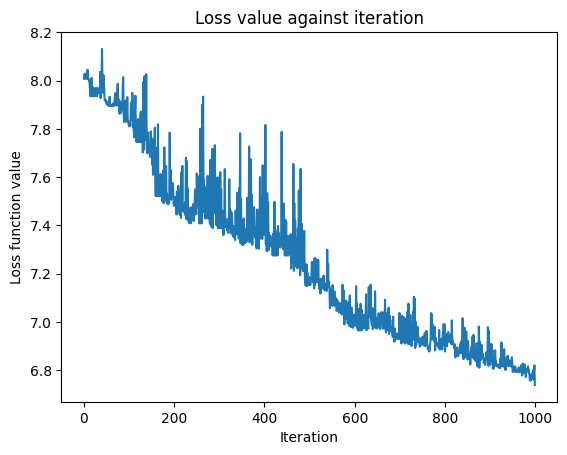

[ 7.50605498e-01  5.66890085e-01  7.31517536e-01  4.96006384e-01
  3.95695906e-01  1.13451110e-01  3.78367229e-01  7.19481924e-01
  9.25665377e-01  5.72345226e-01  8.09711128e-01 -3.23301563e-01
  1.50900241e+00  1.58115491e+00 -3.23201446e-01  1.34678087e-01
  1.24222163e-01 -1.09340993e-03  1.41251250e-01  2.01606058e+00
  6.82573688e-01  3.95835729e-01 -5.48543191e-01 -1.52328326e-01
  7.90597295e-01  1.79217818e+00  5.14415768e-01 -7.93021580e-01
  5.32666004e-01  6.57788659e-01  2.64586003e-01  1.53203525e+00
  1.14814817e+00  9.85954665e-01 -2.69726176e-01  1.60766218e-01
  1.03209928e+00 -1.16085674e-01  1.27948767e-01 -3.56444633e-01
  5.18536946e-01  1.51916691e+00  6.77145271e-01 -7.74780790e-02
  5.65831381e-01  1.63089264e+00 -9.41711521e-02  1.11206448e+00
  4.79665495e-01  1.98254886e+00  1.14276458e+00  1.89679931e+00
  2.32609652e+00  1.39129863e-01  7.33226512e-01  3.47462846e-01
  4.15529550e-01  4.54188108e-01  1.78989349e+00  1.20140553e+00
  7.32431335e-01  6.47868

In [30]:
# Call Training Function and Save as Result
result = fit(iter=1000, fresh_start=False)

In [31]:
savemodel = Model(TorchConnector(estimator, result[0].x))
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "2Classes_Circuit2A_BCELoss")

True


In [32]:
evalmodel = torch.load("2Classes_Circuit2A_BCELoss", weights_only=False).to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 79.6875%
Test Accuracy: 77.34375%


In [33]:
def translate(array):
    arr = []
    for e in array:
        arr.append(round(e.item()))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0], 
 Y:       [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0], 
 output 1: [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,

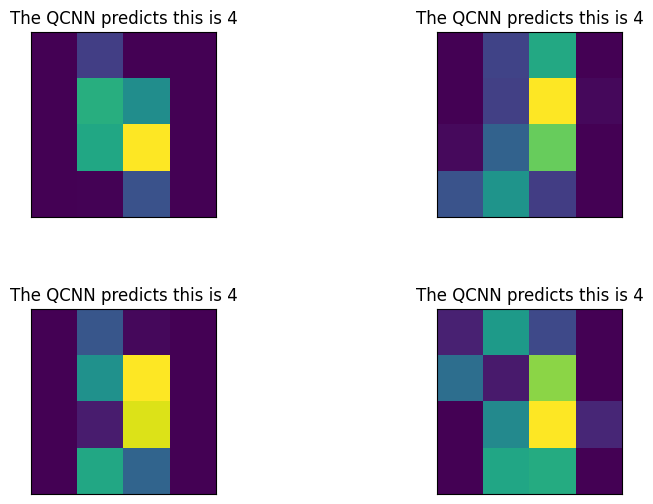

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if round(output1[i].item()) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if round(output1[i].item()) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [38]:
print(result)

( message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 6.73886775970459
       x: [ 7.506e-01  5.669e-01 ...  6.978e-02 -1.039e-01]
    nfev: 1000
   maxcv: 0.0, ['Iteration: 1; Accuracy: 50.78125%; Loss: 8.007495880126953', 'Iteration: 2; Accuracy: 47.65625%; Loss: 8.026904106140137', 'Iteration: 3; Accuracy: 47.65625%; Loss: 8.028985977172852', 'Iteration: 4; Accuracy: 50.78125%; Loss: 8.007495880126953', 'Iteration: 5; Accuracy: 51.5625%; Loss: 8.023296356201172', 'Iteration: 6; Accuracy: 56.25%; Loss: 8.016435623168945', 'Iteration: 7; Accuracy: 50.78125%; Loss: 8.007495880126953', 'Iteration: 8; Accuracy: 46.875%; Loss: 8.015028953552246', 'Iteration: 9; Accuracy: 42.1875%; Loss: 8.044476509094238', 'Iteration: 10; Accuracy: 50.78125%; Loss: 8.007495880126953', 'Iteration: 11; Accuracy: 50.0%; Loss: 8.008634567260742', 'Iteration: 12; Accuracy: 50.0%; Loss: 7.9995574951171875', 'Iteration: 13; Accuracy: 50.0%; Loss: 7.99955749511

In [39]:
result[1]

['Iteration: 1; Accuracy: 50.78125%; Loss: 8.007495880126953',
 'Iteration: 2; Accuracy: 47.65625%; Loss: 8.026904106140137',
 'Iteration: 3; Accuracy: 47.65625%; Loss: 8.028985977172852',
 'Iteration: 4; Accuracy: 50.78125%; Loss: 8.007495880126953',
 'Iteration: 5; Accuracy: 51.5625%; Loss: 8.023296356201172',
 'Iteration: 6; Accuracy: 56.25%; Loss: 8.016435623168945',
 'Iteration: 7; Accuracy: 50.78125%; Loss: 8.007495880126953',
 'Iteration: 8; Accuracy: 46.875%; Loss: 8.015028953552246',
 'Iteration: 9; Accuracy: 42.1875%; Loss: 8.044476509094238',
 'Iteration: 10; Accuracy: 50.78125%; Loss: 8.007495880126953',
 'Iteration: 11; Accuracy: 50.0%; Loss: 8.008634567260742',
 'Iteration: 12; Accuracy: 50.0%; Loss: 7.9995574951171875',
 'Iteration: 13; Accuracy: 50.0%; Loss: 7.9995574951171875',
 'Iteration: 14; Accuracy: 61.71875%; Loss: 7.973790168762207',
 'Iteration: 15; Accuracy: 75.0%; Loss: 7.935135364532471',
 'Iteration: 16; Accuracy: 75.0%; Loss: 7.935135364532471',
 'Iteratio